In [1]:
#%matplotlib nbagg
#%pylab
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
points_recep = sc.read.json('datos/points-recep.jsonlines').rdd

## Utils

In [9]:
def remove_no_receptions(l):
    return list(filter(lambda e: e > 0, l))



### Cantidad de emisiones validas (con datos)

#### (1)  ¿En cuantos puntos tenemos más de una emision en periodos distintos?

<IPython.core.display.Javascript object>


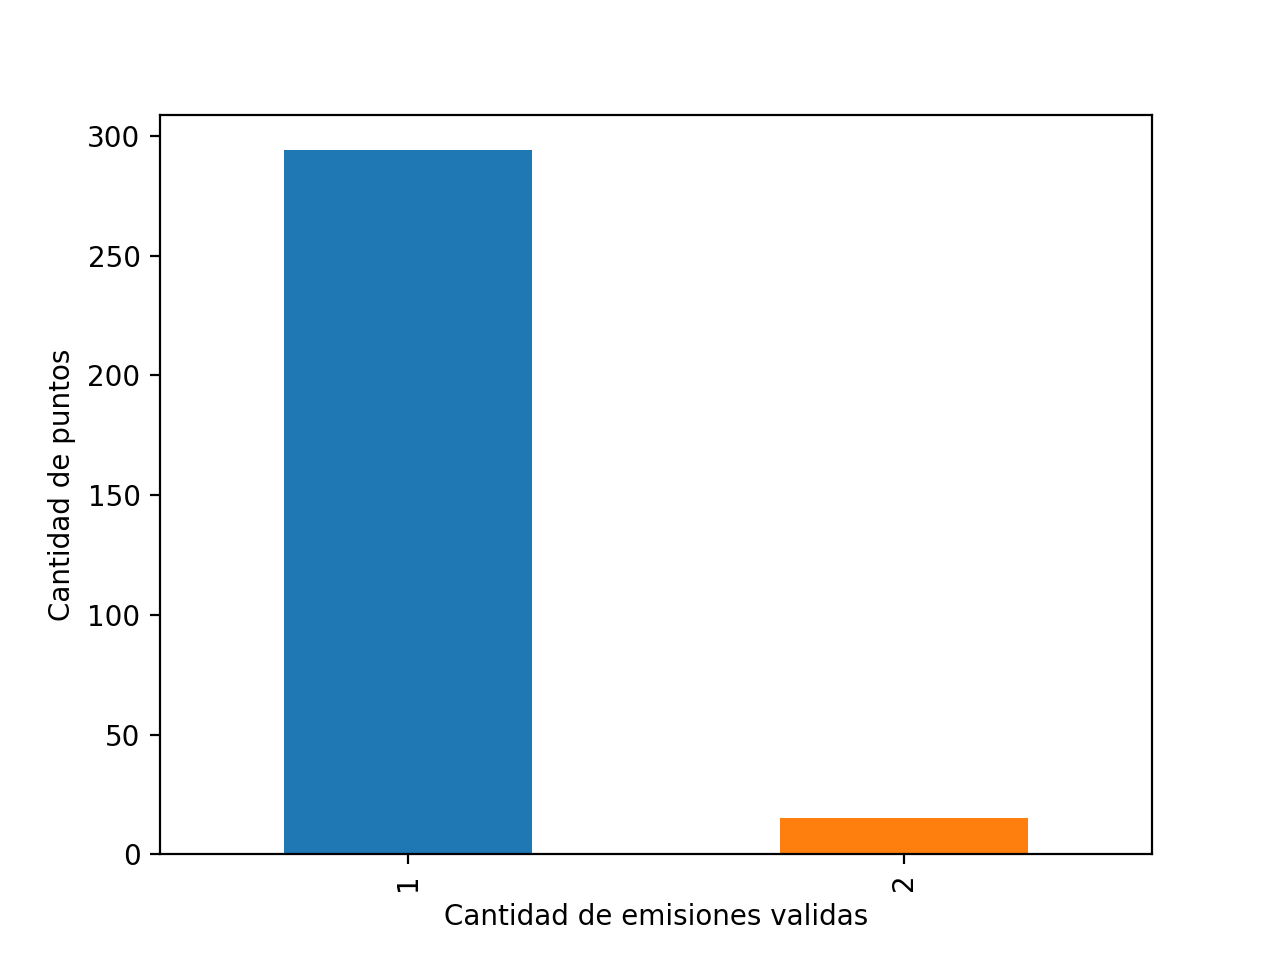

Text(0.5,0,'Cantidad de emisiones validas')

In [11]:
point_emissions = (
    points_recep
    .filter(lambda x: len(x['recep_0']+x['recep_1']+x['recep_2']+x['recep_3']))
    .groupBy(lambda x: x['Punto'])
    .map(lambda x: (x,len(list(x[1]))))
    .groupBy(lambda x: x[1])
    .map(lambda x: {'cant_emissions': x[0], 'cant_points': len(list(x[1]))})
)
p = pd.DataFrame(point_emissions.collect()).plot.bar(x='cant_emissions', y='cant_points', legend=False)
p.set_ylabel('Cantidad de puntos')
p.set_xlabel('Cantidad de emisiones validas')

### Cantidad de recepciones por antena

#### (2) ¿Todas las antenas tienen el mismo impacto? ¿O hay antenas con más emisiones/más puntos alcanzables?

<IPython.core.display.Javascript object>


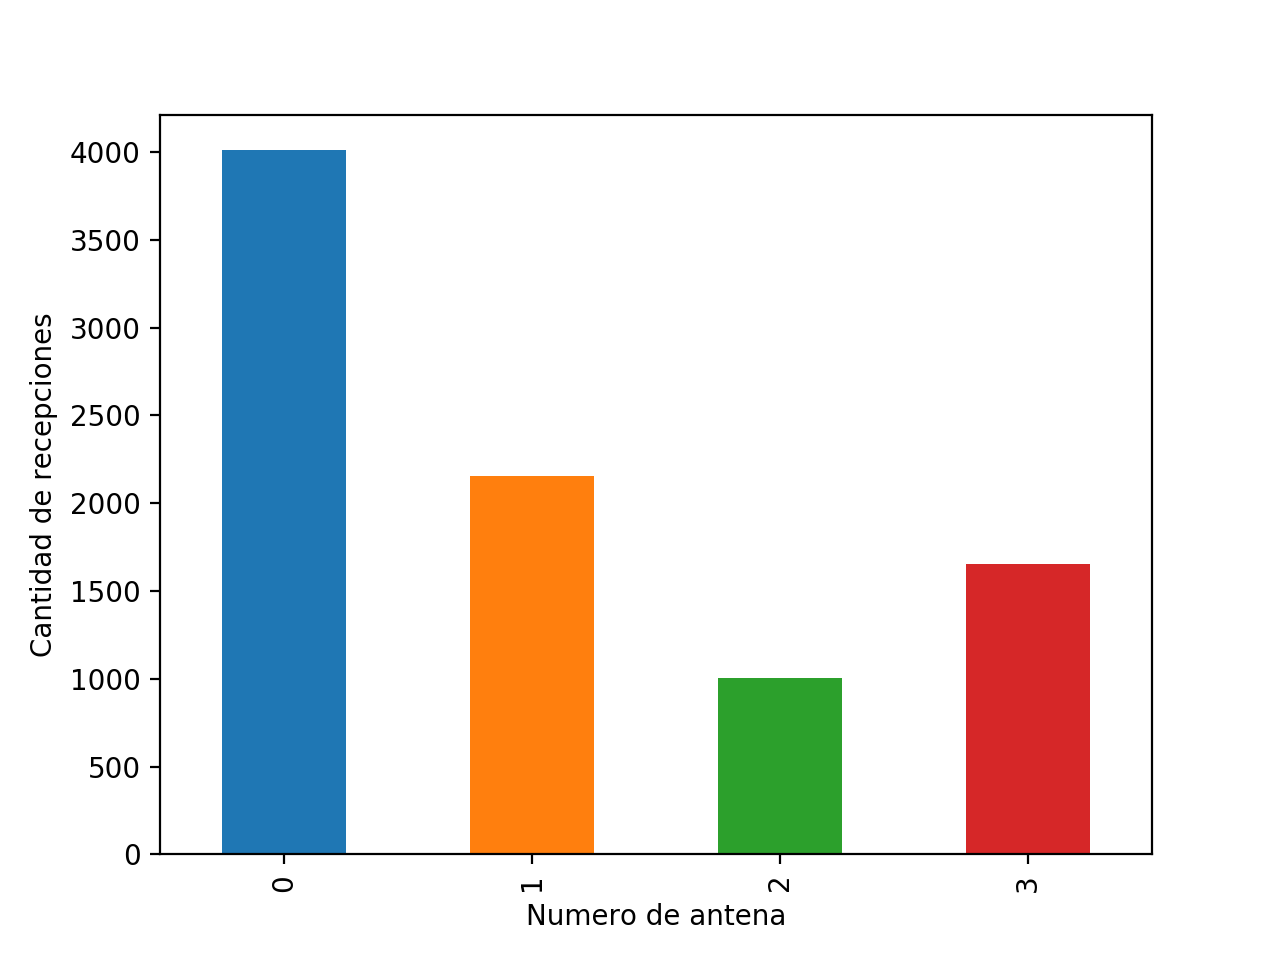

Text(0.5,0,'Numero de antena')

In [74]:
cants_recep_por_antena = []
for i in range(4):
    cant = points_recep.map(lambda x: len(x['recep_{}'.format(i)])).sum()
    cants_recep_por_antena.append({'antenna': i, 'cant_recep': cant})
    
p = pd.DataFrame(cants_recep_por_antena).plot.bar(x='antenna', y='cant_recep', legend=False)
p.set_ylabel('Cantidad de recepciones')
p.set_xlabel('Numero de antena')


### Promedio del promedio y del stdev de las potencias recibidas por emision

#### (3) ¿En cada antena, por que valores de potencia suelen moverse los puntos que le mandan señales?

<IPython.core.display.Javascript object>


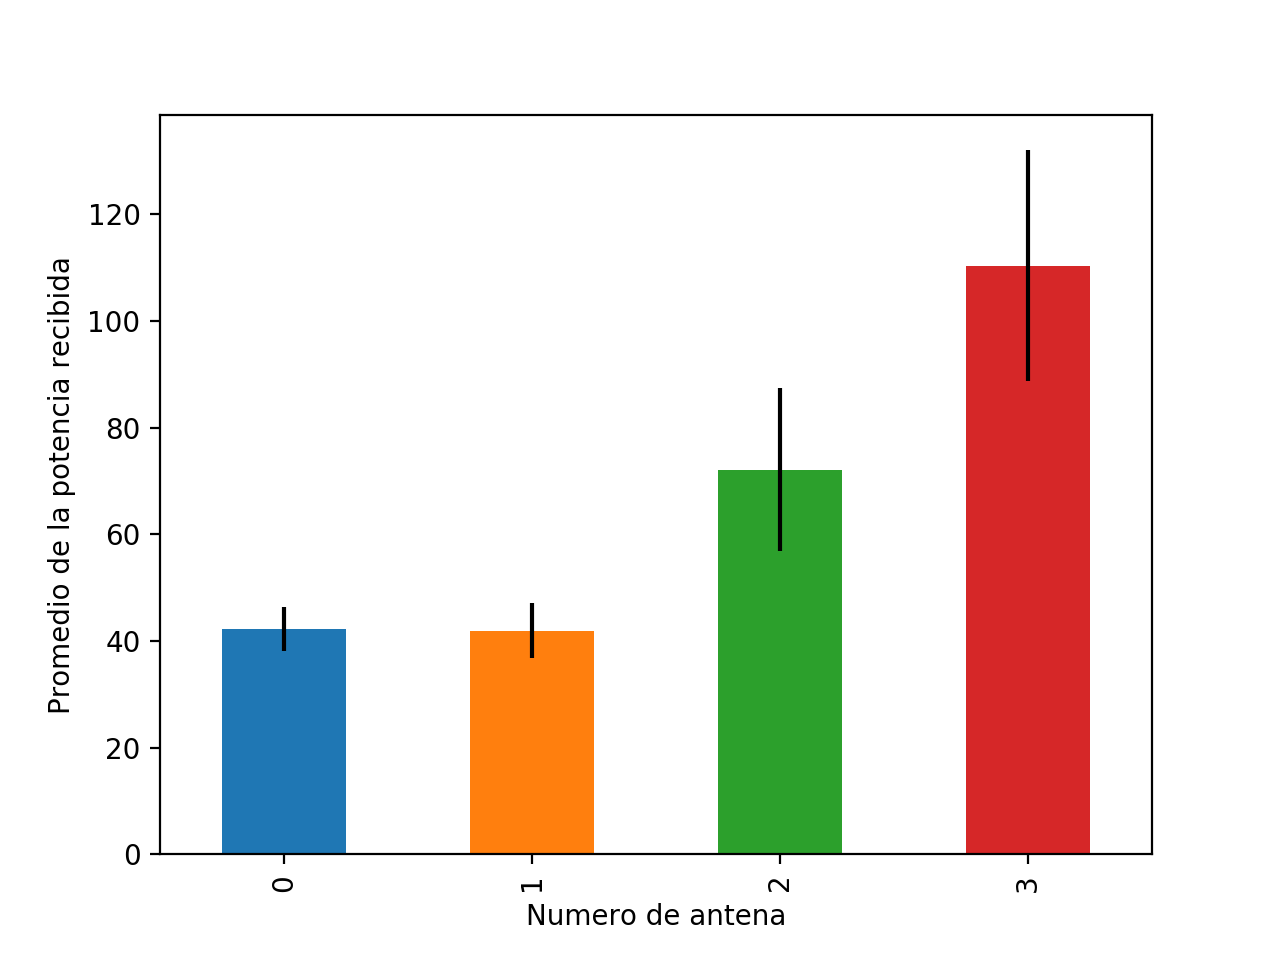

Text(0.5,0,'Numero de antena')

In [12]:
same_emisions_mean_and_std = []
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    mean = recepciones.map(lambda x: np.mean(x)).mean()
    stdev = recepciones.map(lambda x: np.std(x)).mean()
    same_emisions_mean_and_std.append({'antenna': i, 'mean': mean, 'stdev': stdev})
    
p = pd.DataFrame(same_emisions_mean_and_std).plot.bar(x='antenna', y='mean', yerr='stdev', legend=False)
p.set_ylabel('Promedio de la potencia recibida')
p.set_xlabel('Numero de antena')


### Promedio y stdev de las potencias recibidas por antena

#### (3.5) ¿Todas las antenas reciben señales con la misma intensidad?

<IPython.core.display.Javascript object>


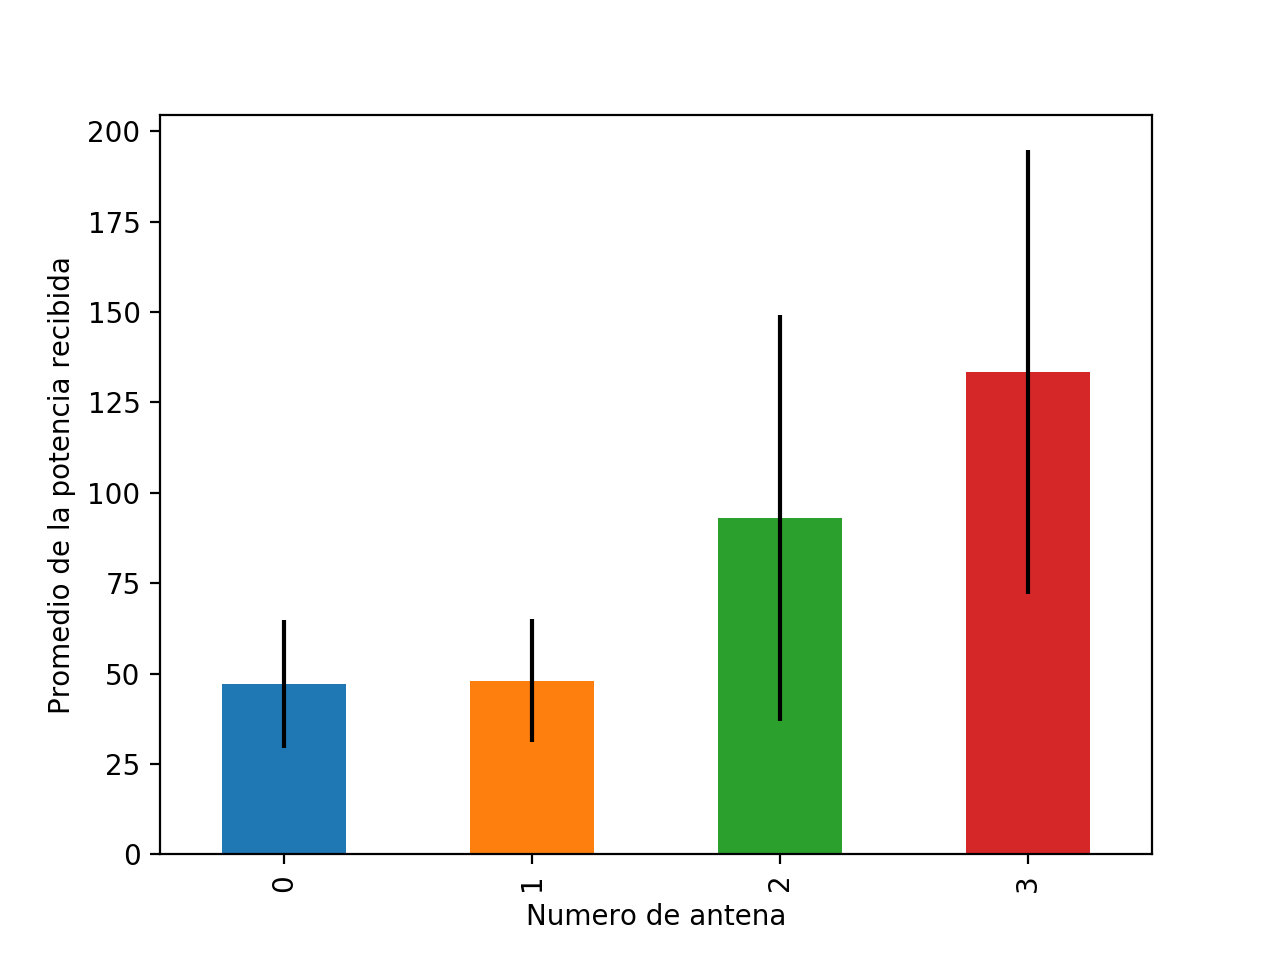

Text(0.5,0,'Numero de antena')

In [13]:
same_emisions_mean_and_std = []
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    mean = recepciones.flatMap(lambda x: x).mean()
    stdev = recepciones.flatMap(lambda x: x).stdev()
    same_emisions_mean_and_std.append({'antenna': i, 'mean': mean, 'stdev': stdev})
    
p = pd.DataFrame(same_emisions_mean_and_std).plot.bar(x='antenna', y='mean', yerr='stdev', legend=False)
p.set_ylabel('Promedio de la potencia recibida')
p.set_xlabel('Numero de antena')


### Ejemplos distribucion de potencia de emisiones

#### (4) ¿Son parecidas las potencias recibidas en una misma emision?

[(235, '2018-02-20 12:09:30'), (362, '2018-02-22 13:05:20'), (177, '2018-02-18 11:51:45'), (174, '2018-02-18 12:11:45'), (188, '2018-02-23 18:15:25')]


<IPython.core.display.Javascript object>


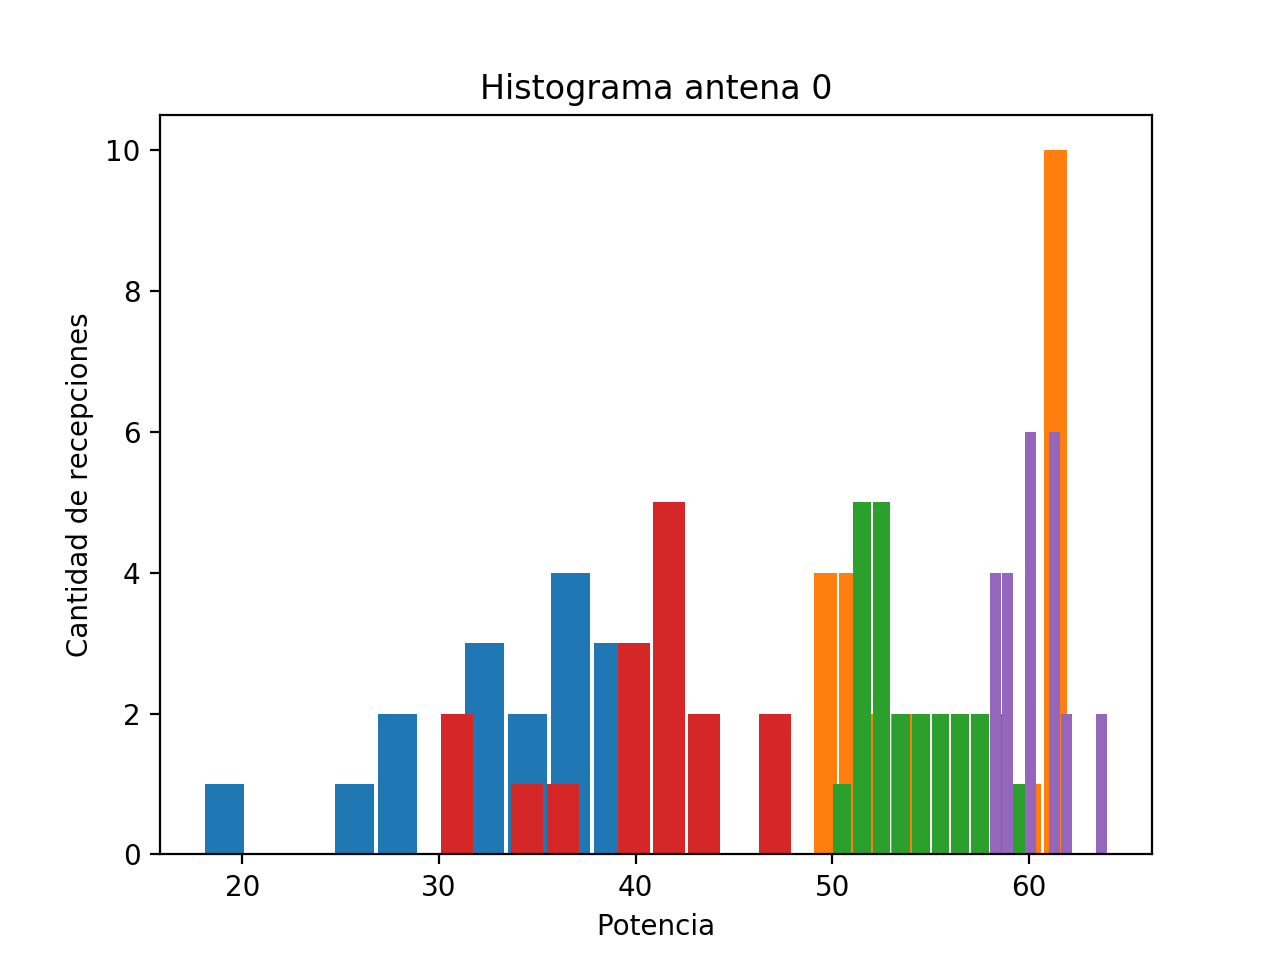

[(410, '2018-02-22 09:11:50'), (268, '2018-01-27 08:11:00'), (388, '2018-02-23 11:33:40'), (513, '2018-02-21 11:01:40'), (377, '2018-02-23 19:31:55')]


<IPython.core.display.Javascript object>


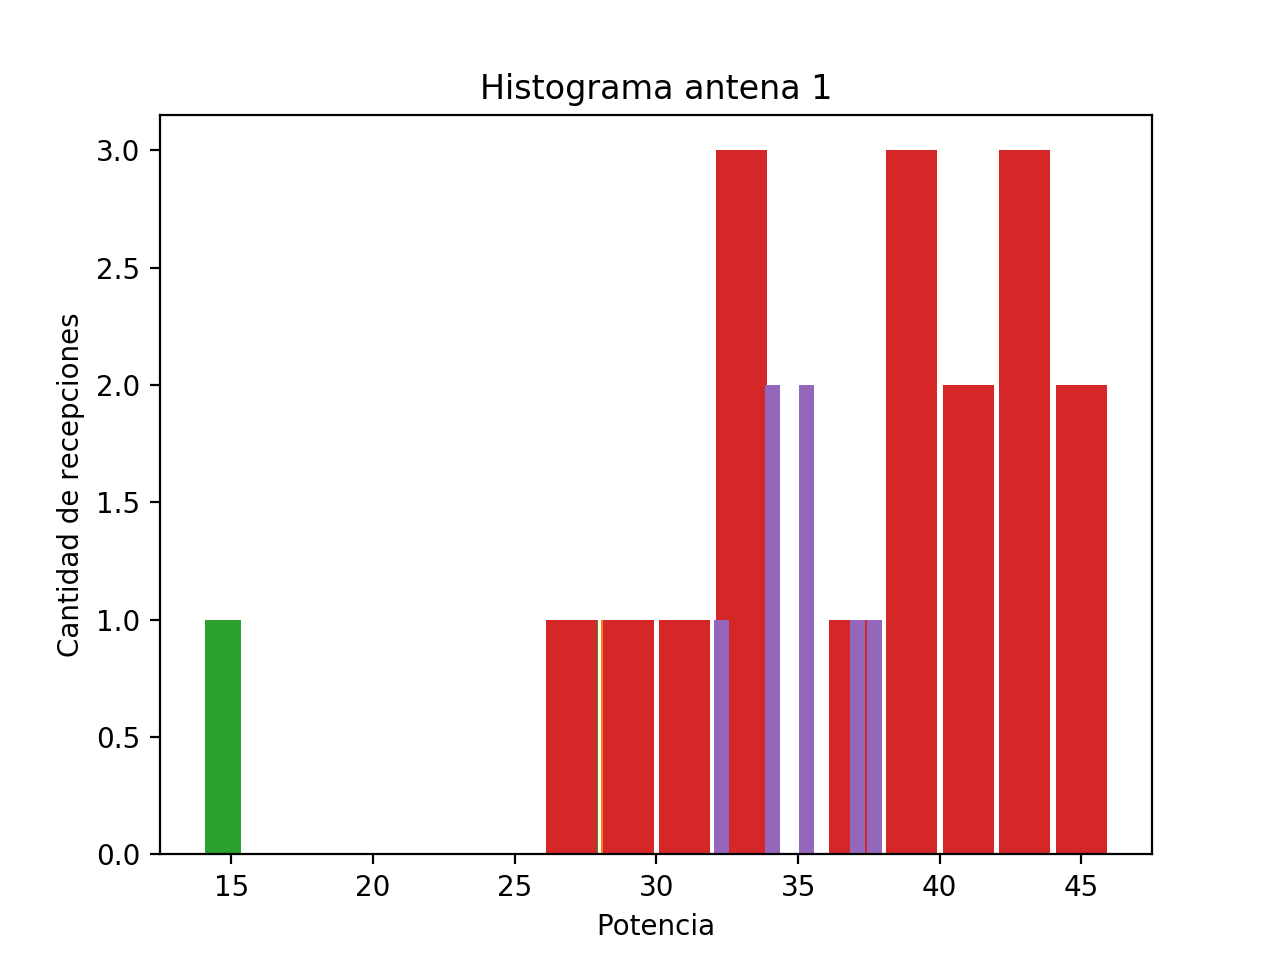

[(241, '2018-02-20 11:44:30'), (219, '2018-01-27 07:42:30'), (268, '2018-01-27 08:11:00'), (262, '2018-01-27 10:21:15'), (334, '2018-02-20 11:05:45')]


<IPython.core.display.Javascript object>


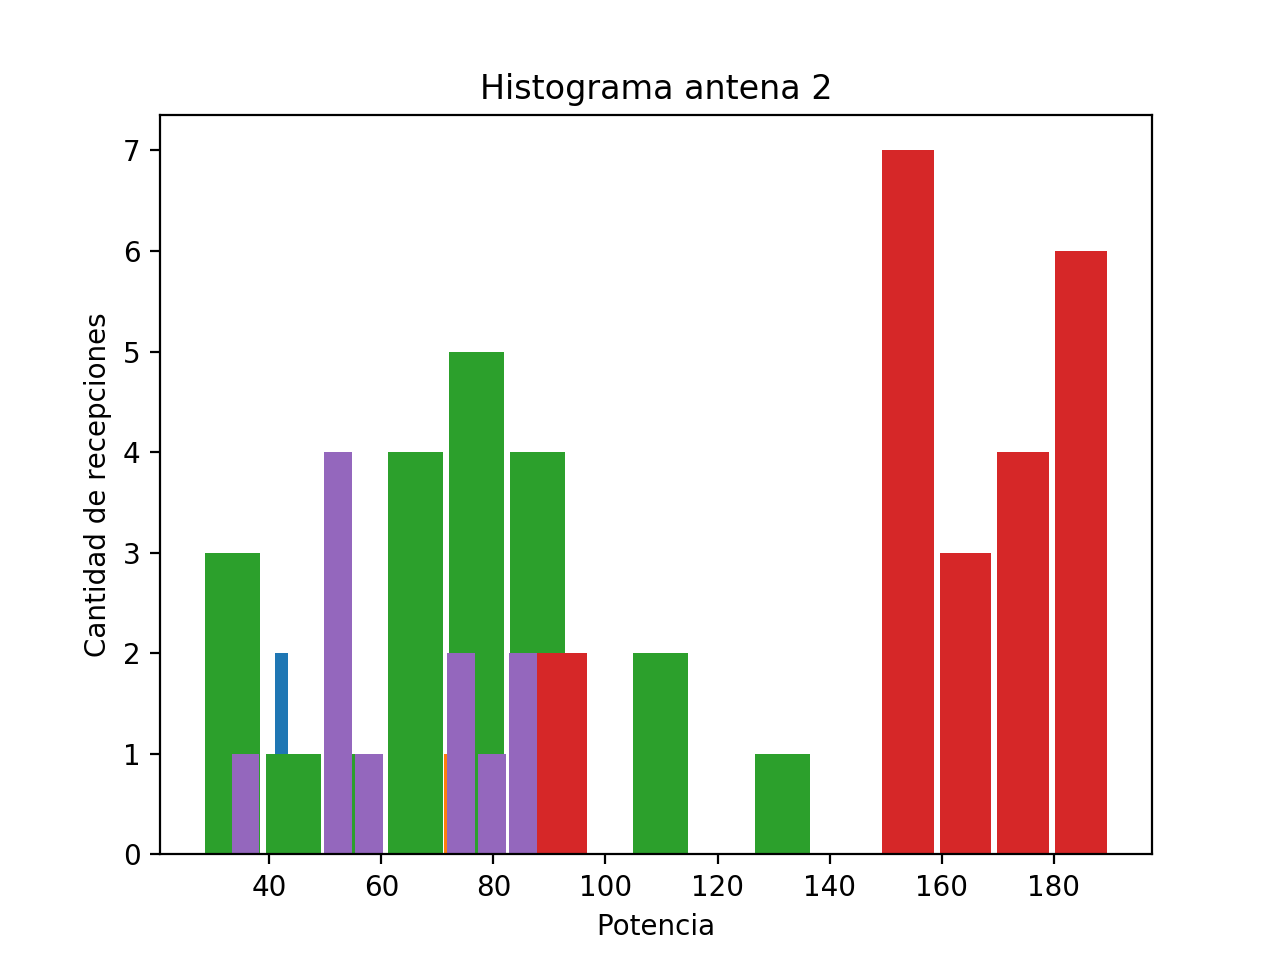

[(386, '2018-02-20 17:21:10'), (410, '2018-02-22 09:11:50'), (365, '2018-02-23 12:05:35'), (244, '2018-01-27 08:20:00'), (311, '2018-02-22 11:27:00')]


<IPython.core.display.Javascript object>


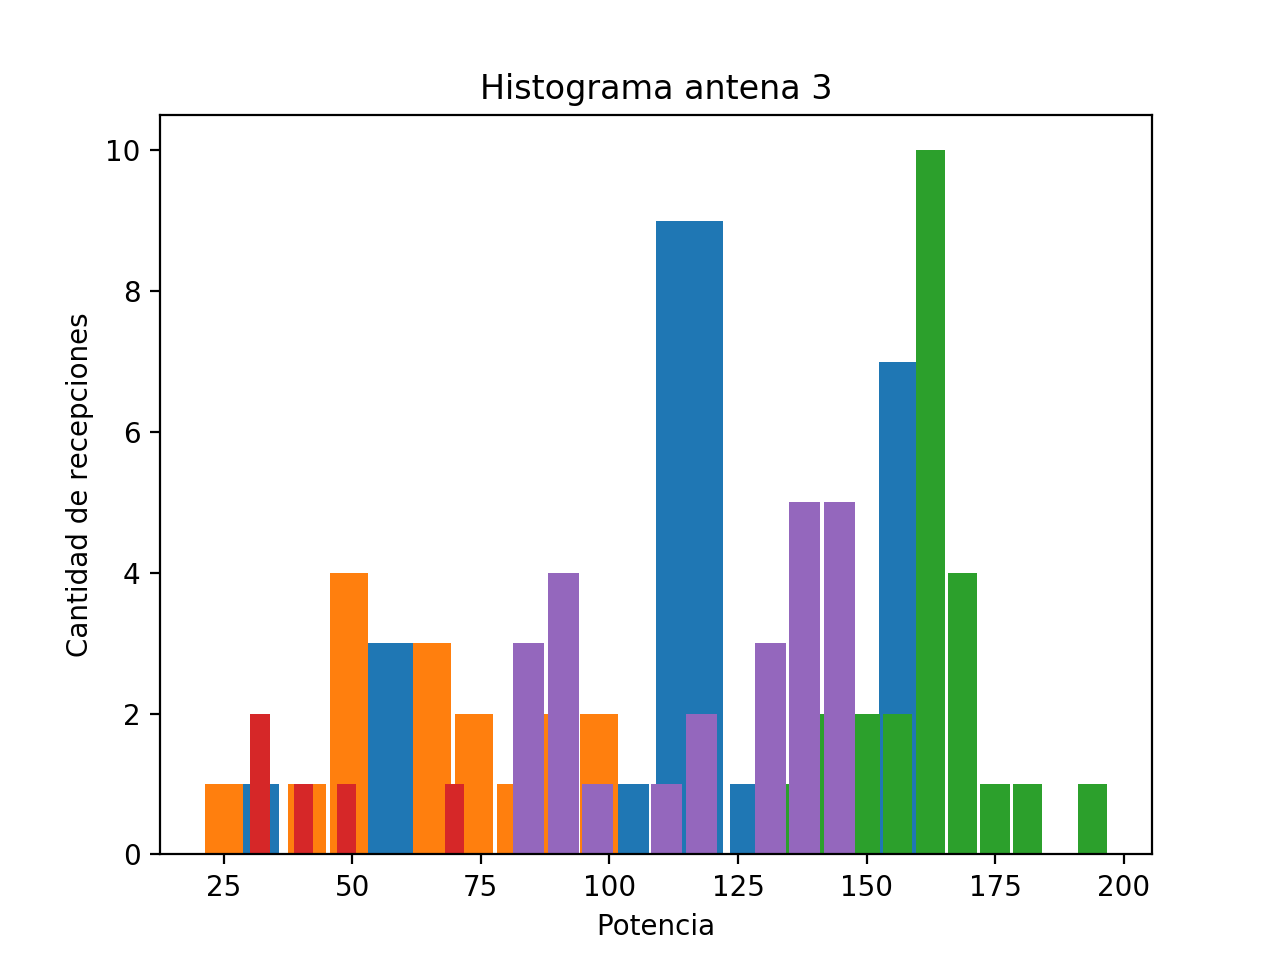

In [67]:

for i in range(4):
    recep_field = 'recep_{}'.format(i)
    
    puntos_ejemplos = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: (x['Punto'], x['timestamp_inicio'])).takeSample(False, 5)
    l = points_recep.filter(lambda x: (x['Punto'], x['timestamp_inicio']) in puntos_ejemplos).map(lambda x: x[recep_field]).collect()
    print(puntos_ejemplos)
    
    plt.figure()
    plt.title('Histograma antena {}'.format(i))
    for i in range(len(l)):
        plt.hist(l[i], rwidth=0.9)
        plt.xlabel('Potencia')
        plt.ylabel('Cantidad de recepciones')
    



### Ejemplos de distintas emisiones de un mismo punto

#### (5) ¿Son parecidas las distintas emisiones de un mismo punto? 

Point 336
28.0
37.578947368421055


<IPython.core.display.Javascript object>


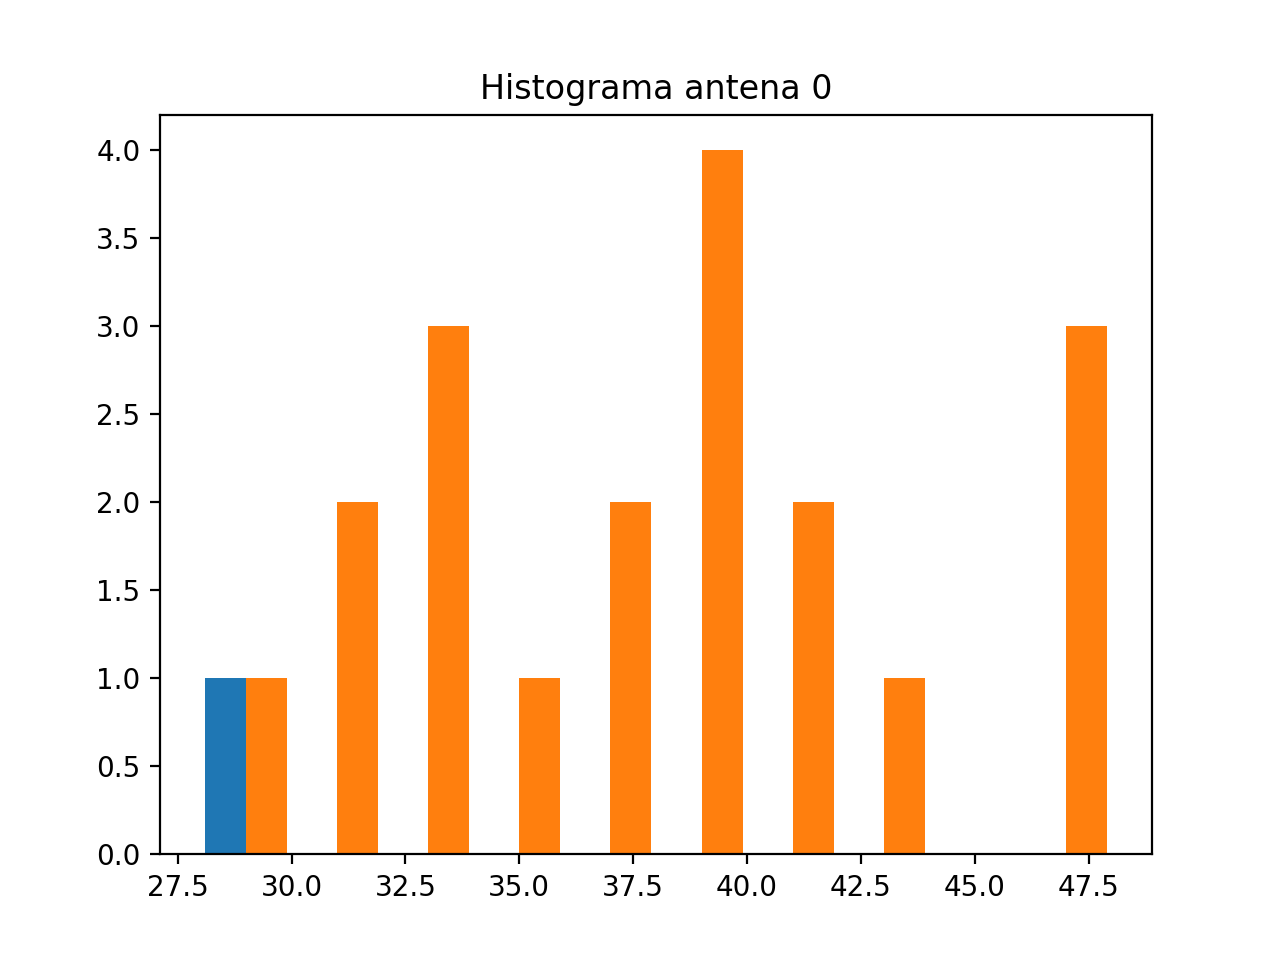

Point 268
31.333333333333332
21.0


<IPython.core.display.Javascript object>


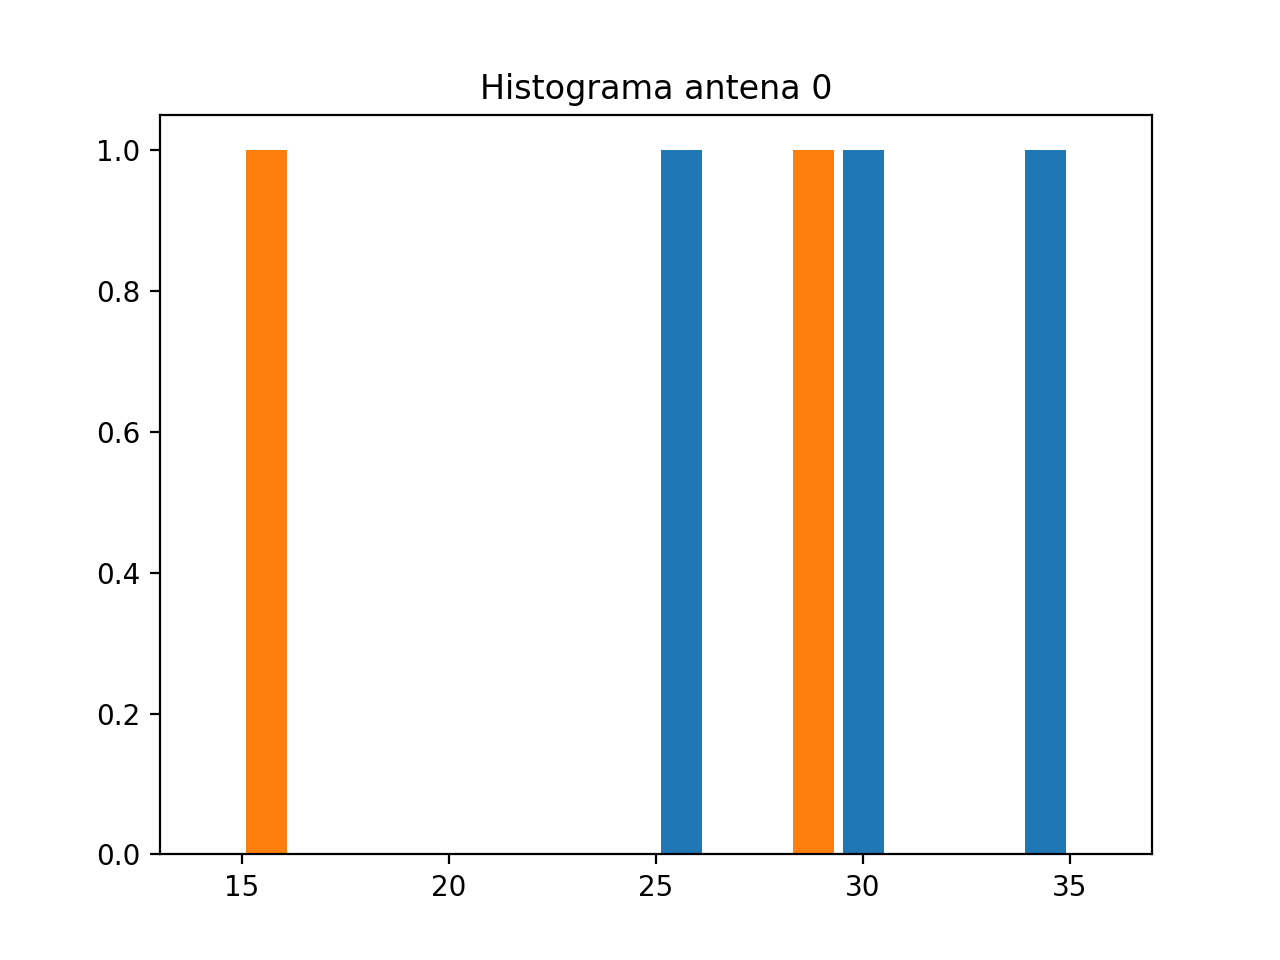

Point 222
239.0
191.66666666666666


<IPython.core.display.Javascript object>


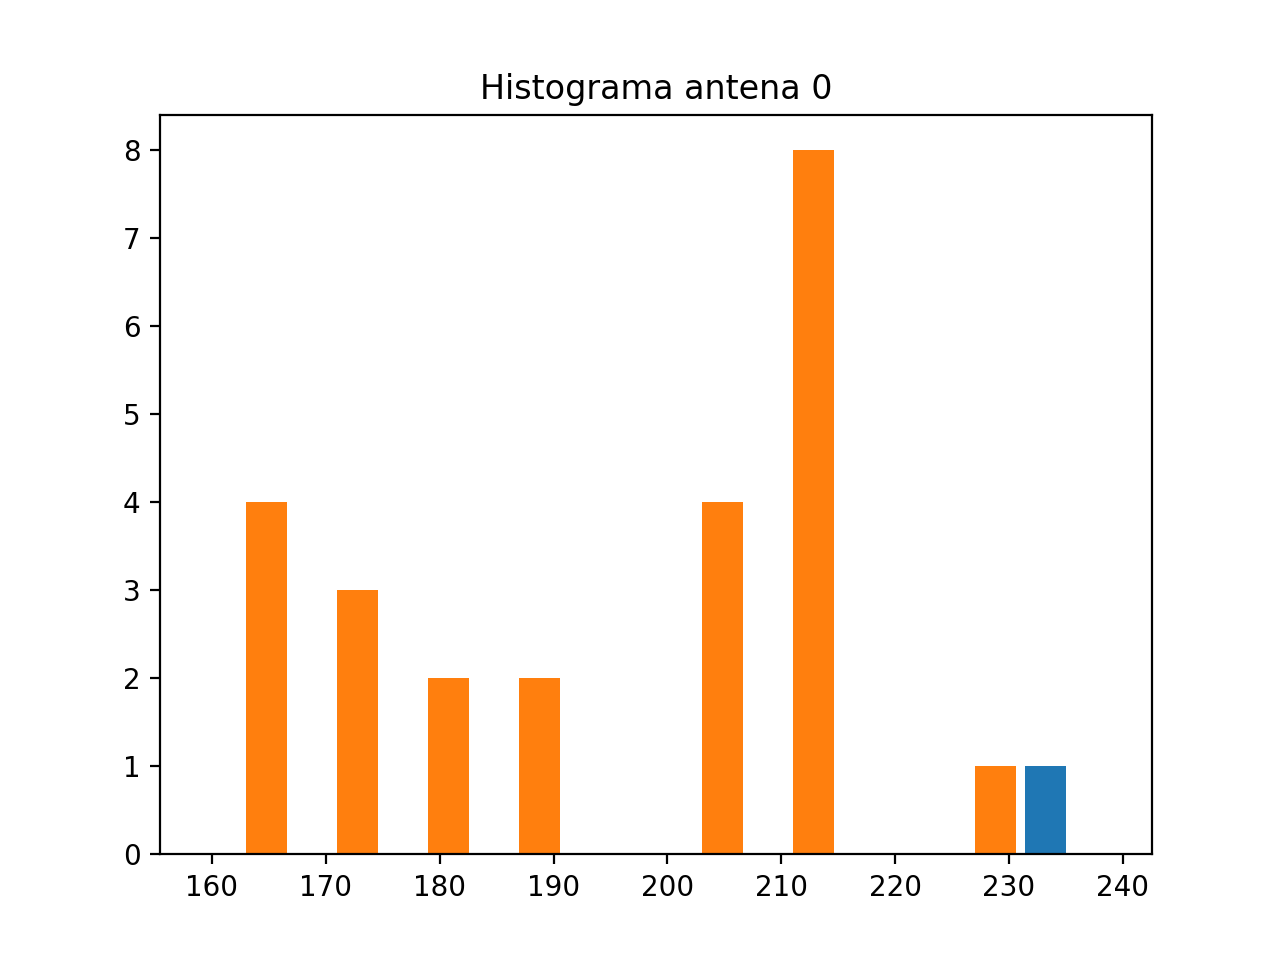

In [48]:
for i in range(3):
    recep_field = 'recep_{}'.format(i)
    points_with_many_emisions = points_recep.filter(lambda x: len(x[recep_field]) > 0).groupBy(lambda x: x['Punto']).filter(lambda x: len(x[1]) > 1)
    point_to_examine = points_with_many_emisions.map(lambda x: x[0]).takeSample(False,1)

    example = (
        points_with_many_emisions
        .filter(lambda x: x[0] in point_to_examine)
        .map(lambda x: [recep[recep_field] for recep in list(x[1])]).collect()
    )
    print('Point {}'.format(point_to_examine[0]))
    for i in range(len(example)):
        print(np.mean(example[i][0]))
        print(np.mean(example[i][1]))
    
    
    plt.figure()
    plt.title('Histograma antena {}'.format(i))
    for i in range(len(example)):
        plt.hist(example[i], rwidth=0.9)
    
    

    
    


### Variación de la potencia de las señales en funcion de la cantidad de señales recibidas

#### (6) ¿Es cierto que mientras más potencia tenga una señal, es mas probable que llegue a la antena?

/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


<IPython.core.display.Javascript object>


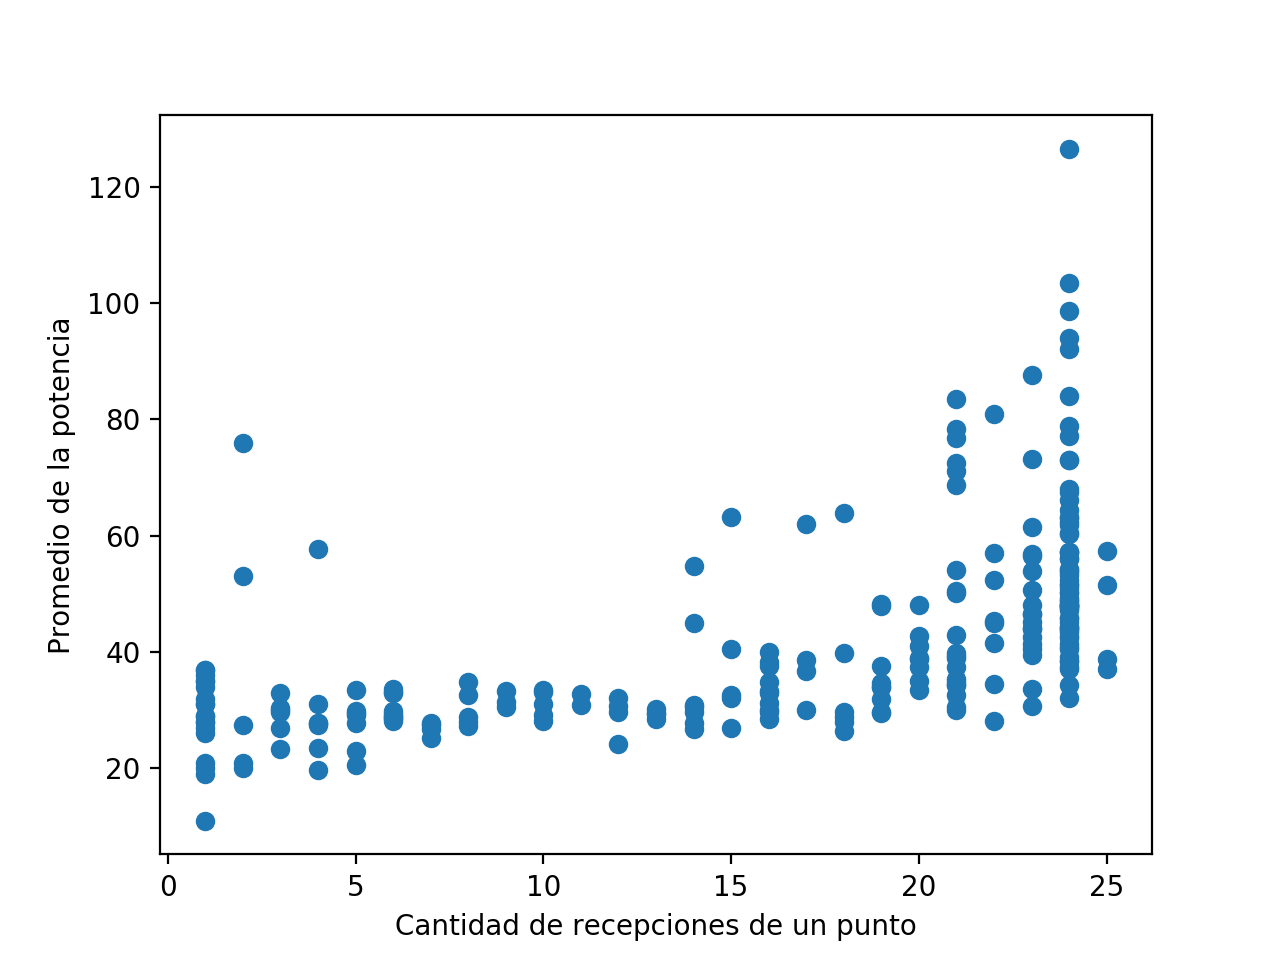

<IPython.core.display.Javascript object>


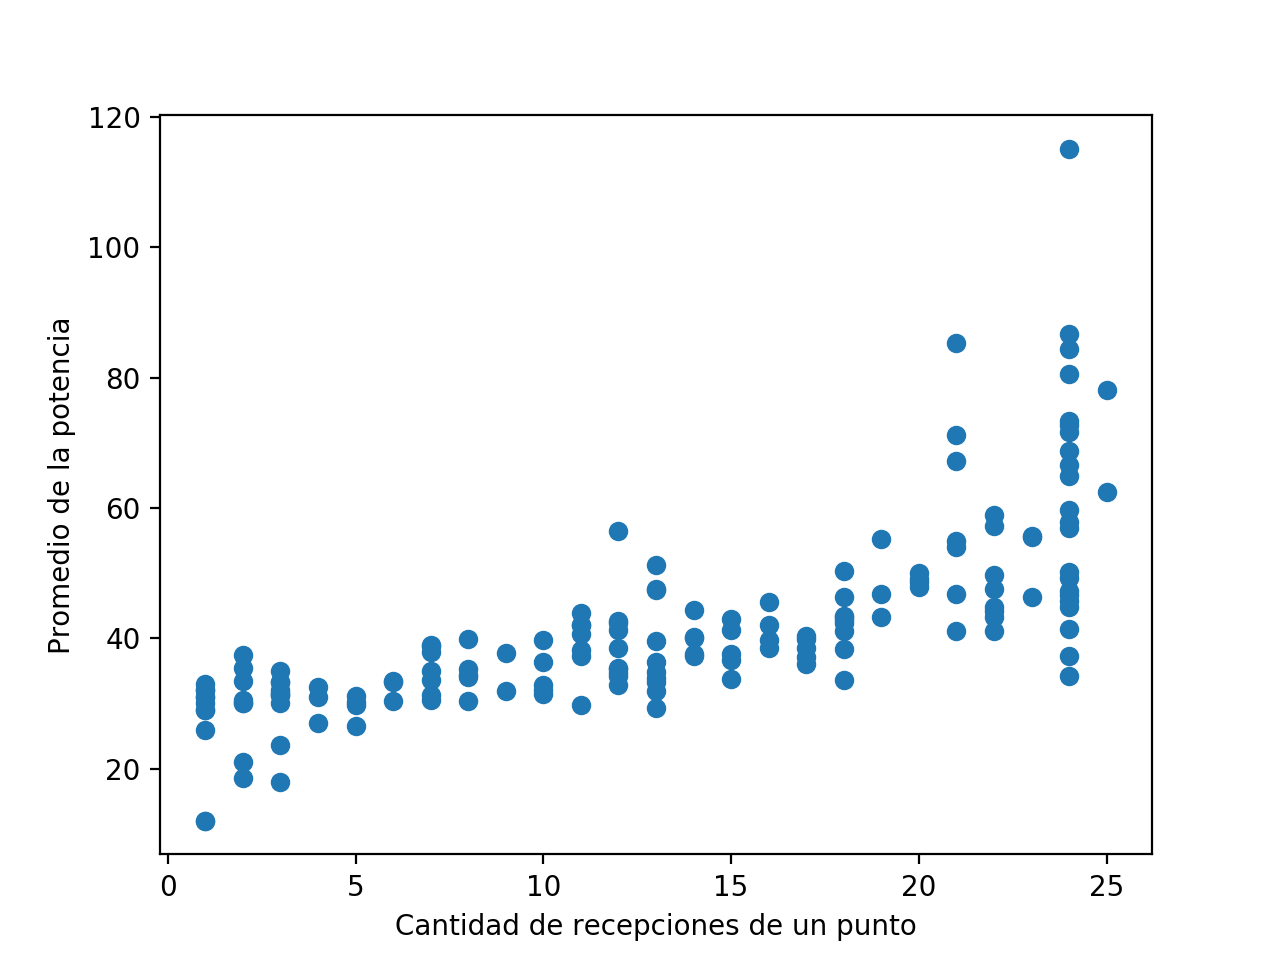

<IPython.core.display.Javascript object>


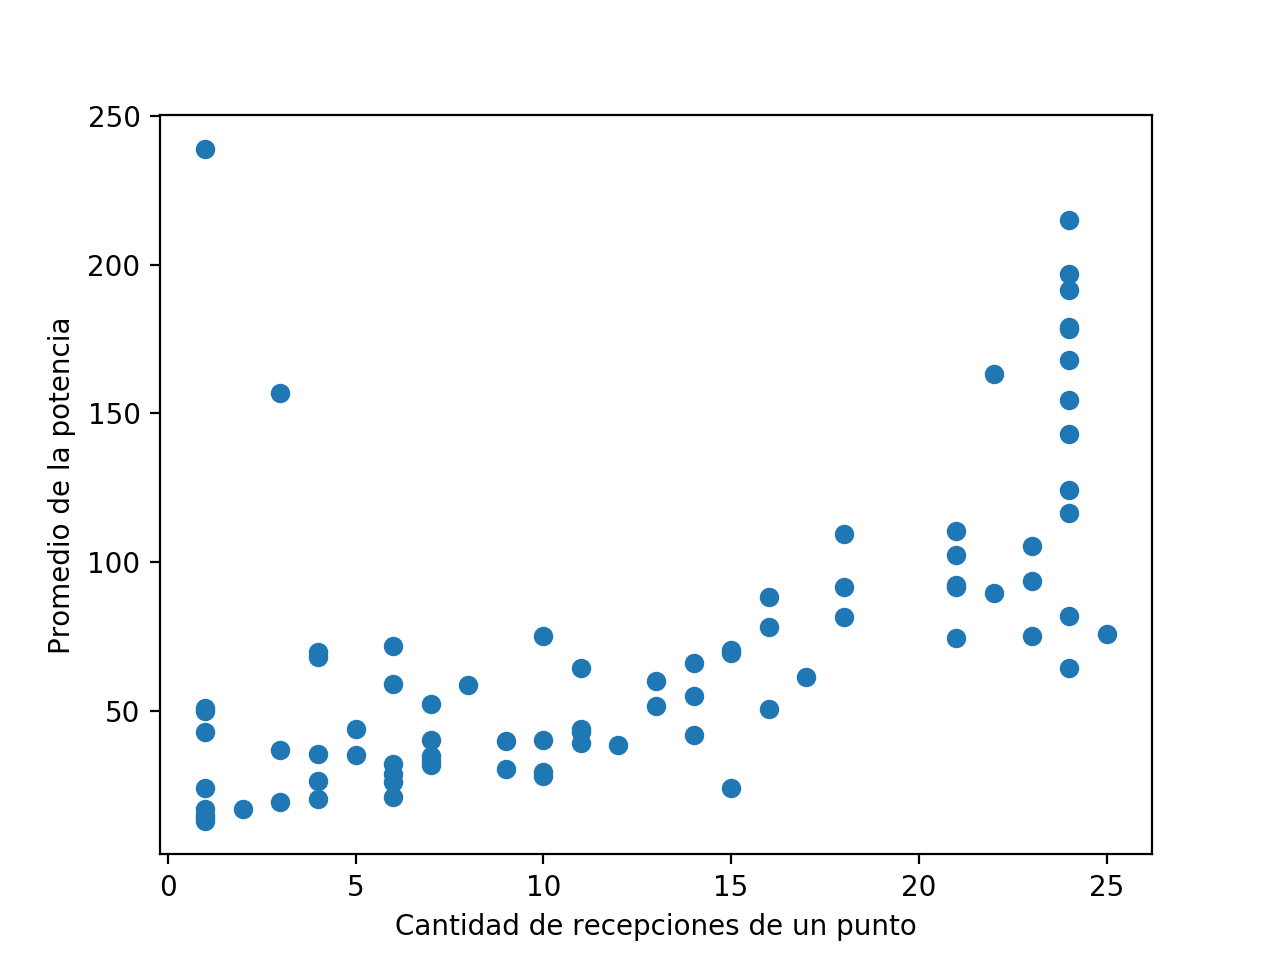

<IPython.core.display.Javascript object>


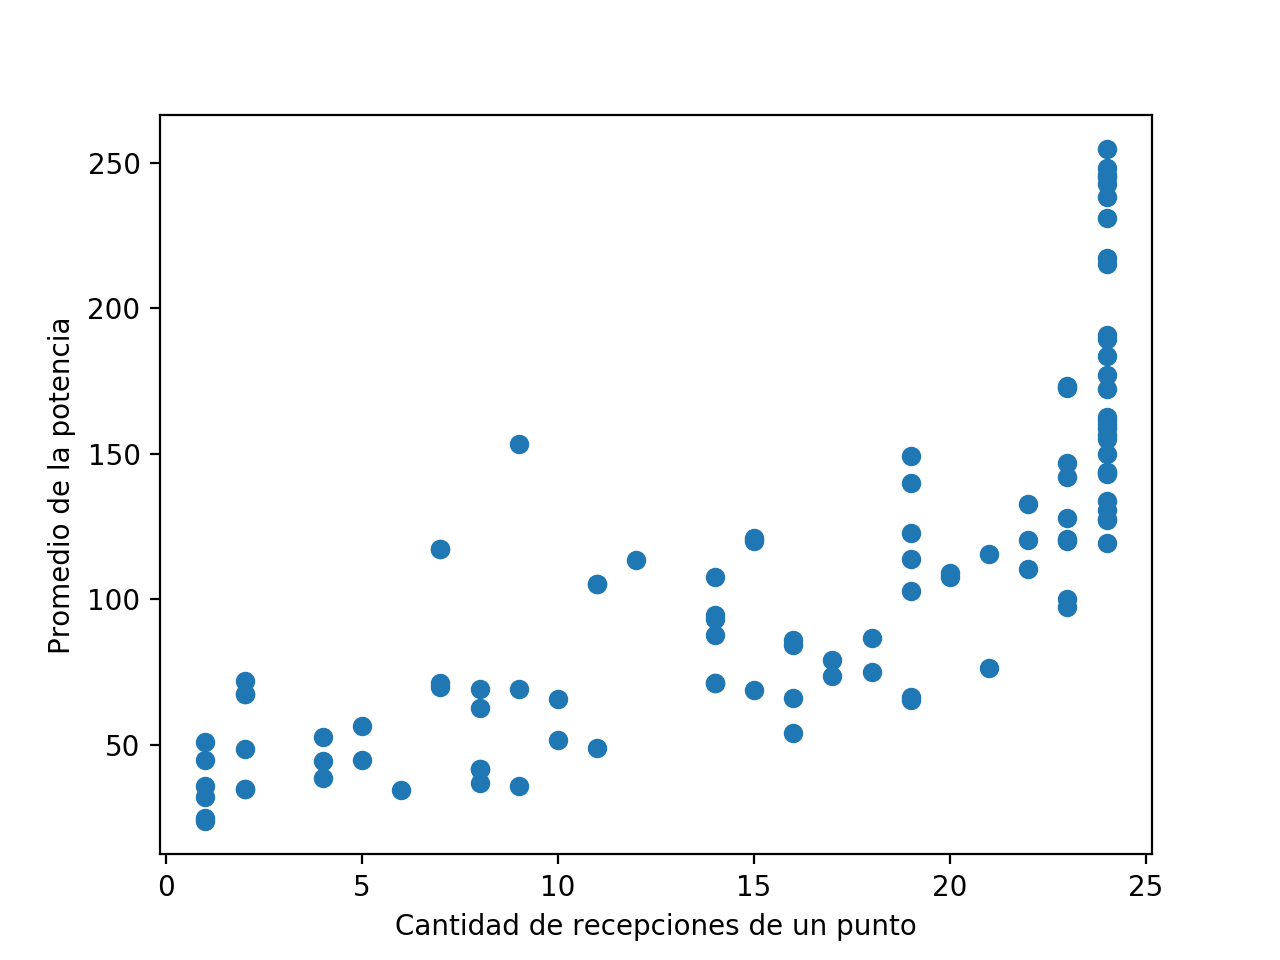

In [70]:
class DataBuilder:
    def __init__(self, something, data):
        self.data = data
        self.something = something
        self.cid = something.canvas.mpl_connect('button_press_event', self)
        self.ann = plt.annotate('', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    def __call__(self, event):
        point = list(filter(lambda x: abs(x['n']-event.xdata) < 1 and abs(x['mean']-event.ydata) < 1, self.data))
        self.ann.remove()
        self.ann = plt.annotate(str(point), (0,0), (0, 280), xycoords='axes fraction', textcoords='offset points', va='top')
        
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    p = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: {'Punto': x['Punto'],'n': len(x[recep_field]),'mean': float(np.mean(x[recep_field]))})
    p_pd = p.toDF().toPandas()
    fig, ax = plt.subplots()
    ax.scatter(p_pd['n'], p_pd['mean'])
    ax.set_xlabel('Cantidad de recepciones de un punto')
    ax.set_ylabel('Promedio de la potencia')
    DataBuilder(fig, p.collect())




### Mapa con colores con la intensidad de la señal recibida en cada antena por los puntos

#### (7) ¿Como es la distribucion espacial de las potencias?

In [71]:
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
coordenadas_UTM = sc.read.csv('datos/DistancesCoordenadasUTM.csv', header=True, inferSchema=True).rdd



In [72]:
def calculate_avg_power(grouped_row, antena):
    signals = list(map(lambda x: x['recep_{}'.format(antena)], list(grouped_row[1])))
    signals_pd = pd.DataFrame([s for emision in signals for s in emision ])
    n = len(signals_pd)
    if n > 0:
        mean = float(signals_pd.mean()[0])
        stdev = float(signals_pd.std()[0])
    else:
        mean = 0
        stdev = 0
    return {
        'Punto': grouped_row[0],
        'mean': mean,
        'stdev': stdev,
        'n': n,
        'x': list(grouped_row[1])[0]['x'],
        'y': list(grouped_row[1])[0]['y']
    }


In [73]:
x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111

global x_0
global y_0

def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


/Users/alew/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


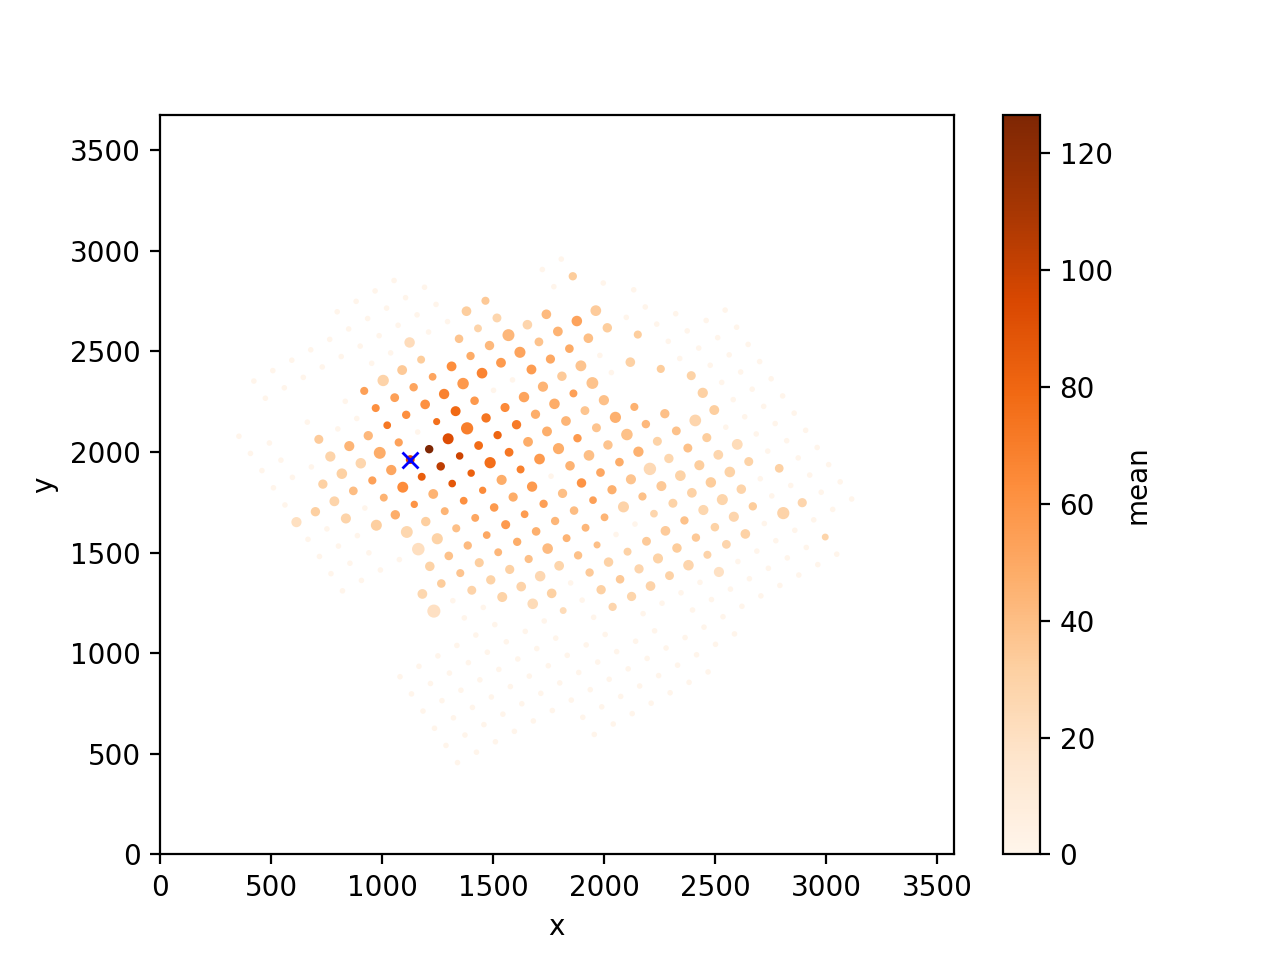

<IPython.core.display.Javascript object>


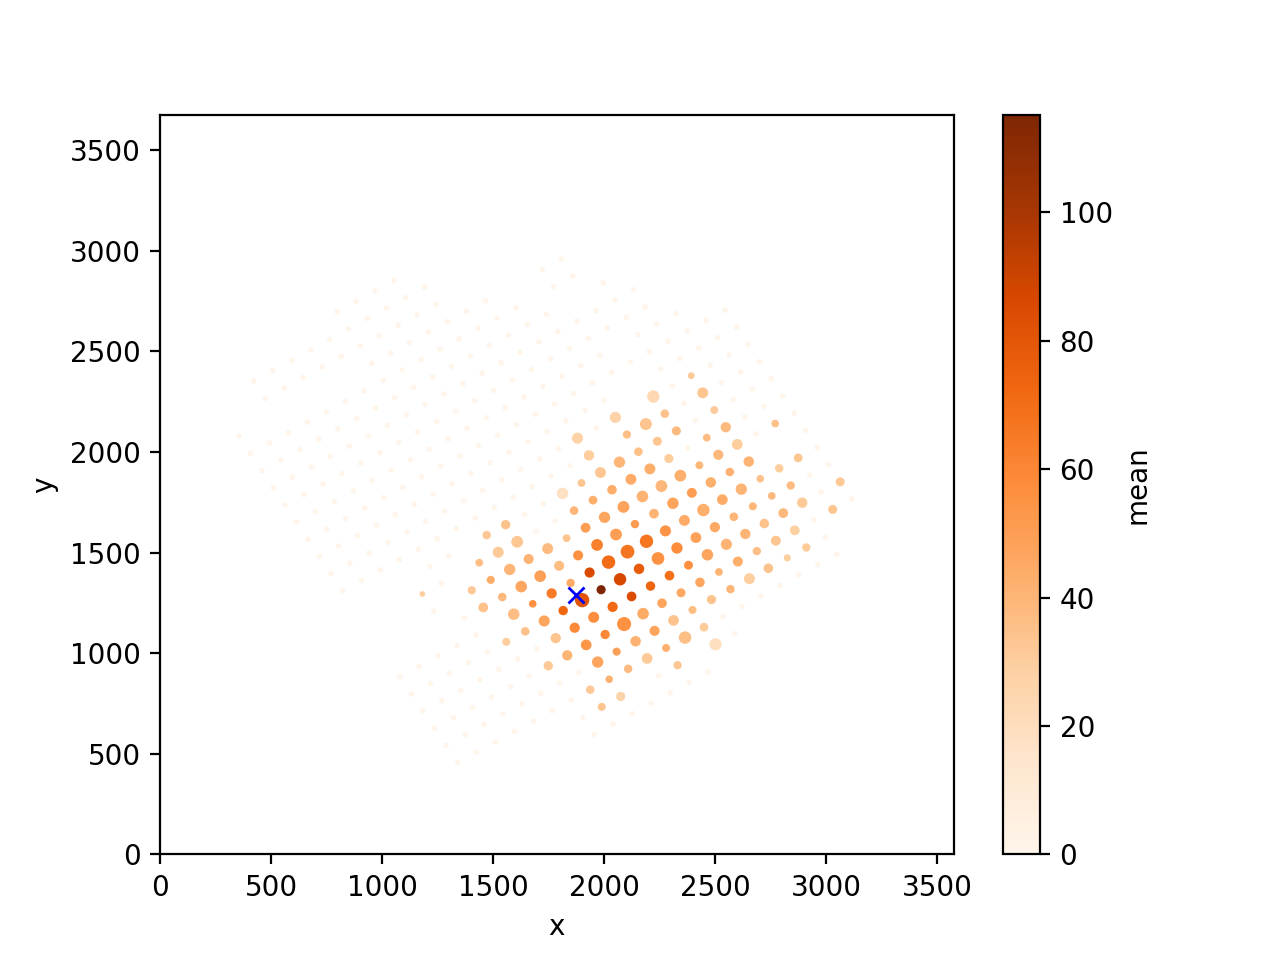

<IPython.core.display.Javascript object>


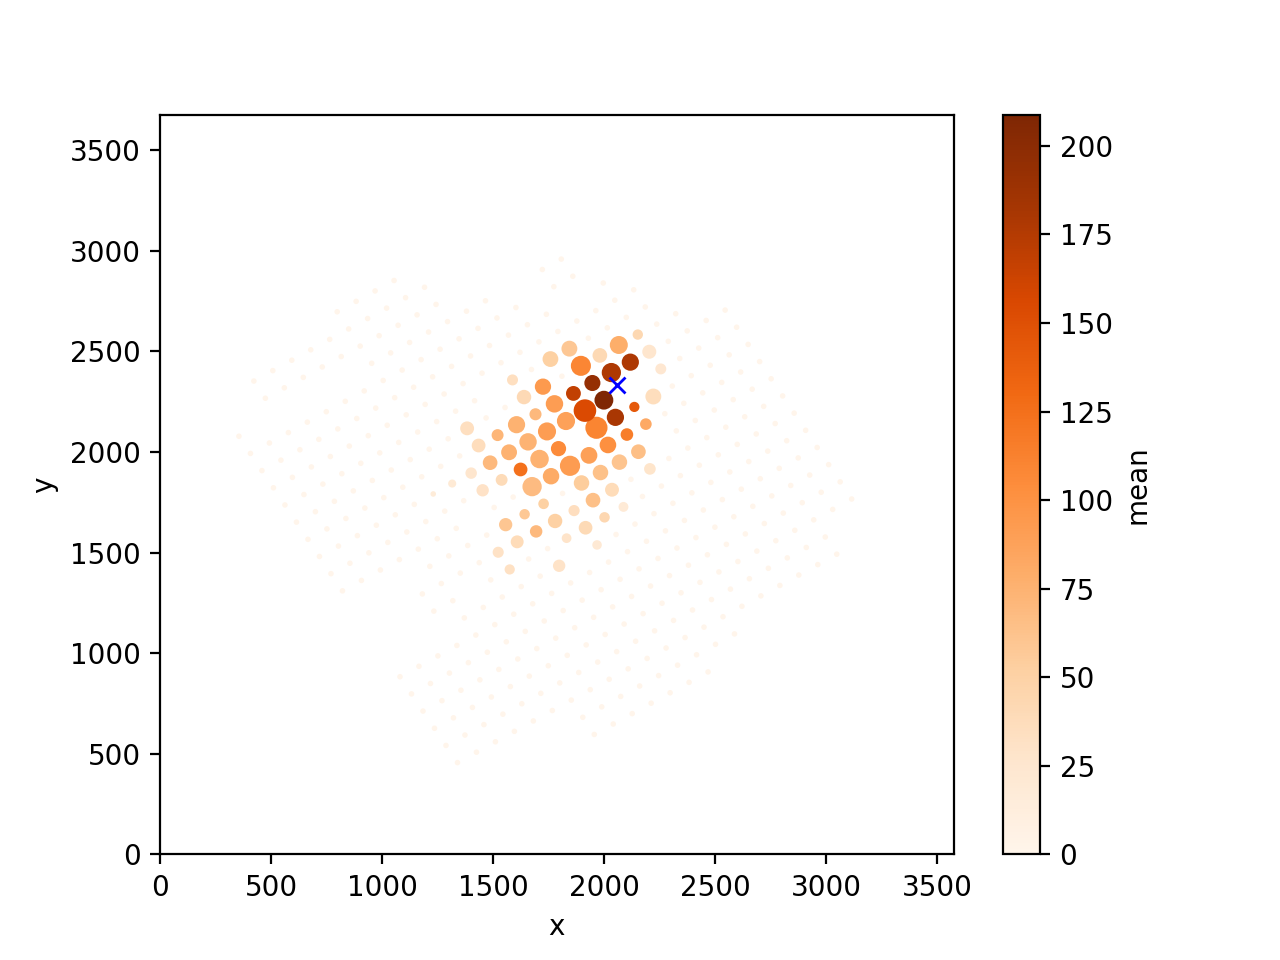

<IPython.core.display.Javascript object>


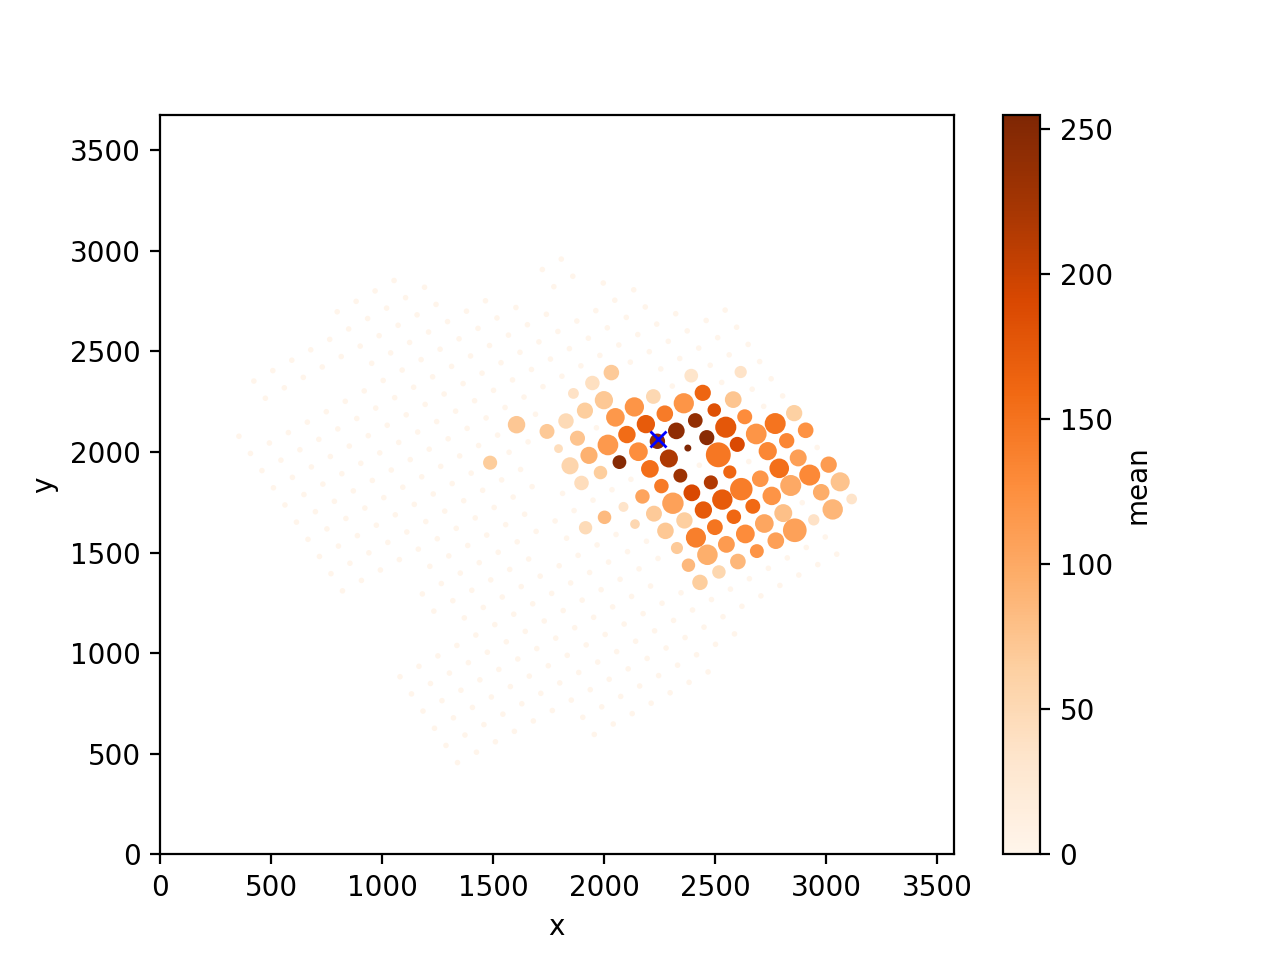

In [84]:

for antena in range(4):
    points_sig = points_recep.groupBy(lambda x:x['Punto']).map(lambda x: calculate_avg_power(x,antena)).map(normalize_positions)#.filter(lambda x: x['mean'] != 0)
    data = pd.DataFrame(points_sig.collect())
    ax = data.plot.scatter(x='x', y='y',c='mean',cmap='Oranges',s=data['stdev']+1)

    pos_antena = posicion_antenas[antena]
    ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "xb")
    
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    

### Mapa con la cantidad de antenas usadas por punto

#### (8) ¿Cuantas antenas utiliza cada punto?

In [75]:
def calculate_amount_antennas_recep(grouped_row):
    signals = list(map(lambda x: [len(x['recep_{}'.format(i)])>0 for i in range(4)], list(grouped_row[1])))

    has_recep_by_antenna = np.array([False, False, False, False])
    for l in signals:
        has_recep_by_antenna = has_recep_by_antenna | np.array(l)

    return {
        'Punto': grouped_row[0],
        'cant': sum(has_recep_by_antenna),
        'x': list(grouped_row[1])[0]['x'],
        'y': list(grouped_row[1])[0]['y']
    }


<IPython.core.display.Javascript object>


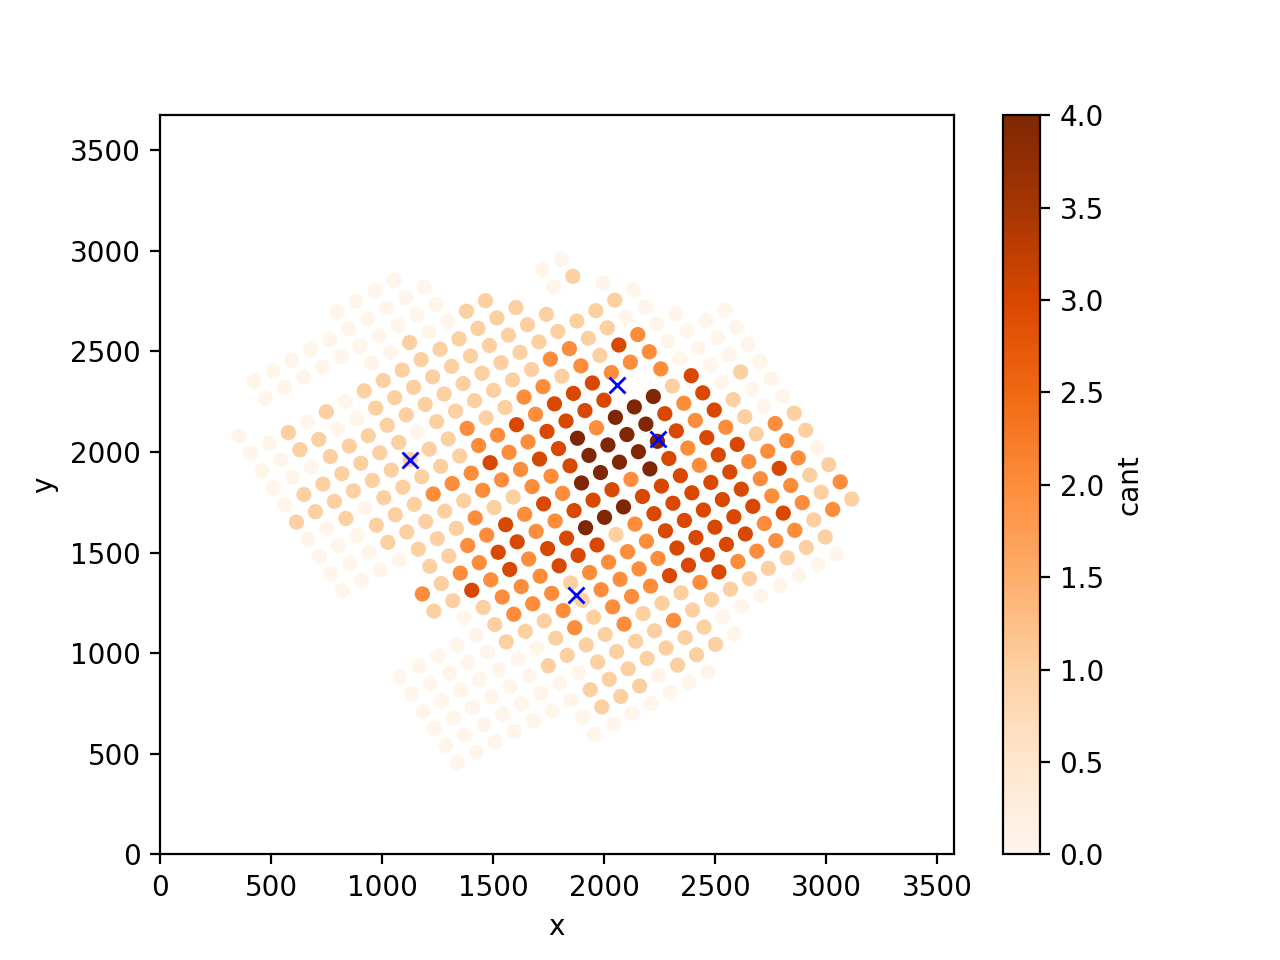

(0, 3572.611122813949)

In [76]:
points_sig = points_recep.groupBy(lambda x:x['Punto']).map(calculate_amount_antennas_recep).map(normalize_positions)
ax = pd.DataFrame(points_sig.collect()).plot.scatter(x='x', y='y',c='cant',cmap='Oranges')

for i in range(4):
    pos_antena = posicion_antenas[i]
    ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "xb")
    
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)

### Cantidad de puntos que usan _x_ cantidad de antenas

#### (9) ¿Cuantos puntos usan 1 antena? ¿Y 2 antenas?

In [77]:
cant_recep = points_sig.groupBy(lambda x: x['cant']).map(lambda x: {'antennas': x[0],'cant_points': len(x[1])})

<IPython.core.display.Javascript object>


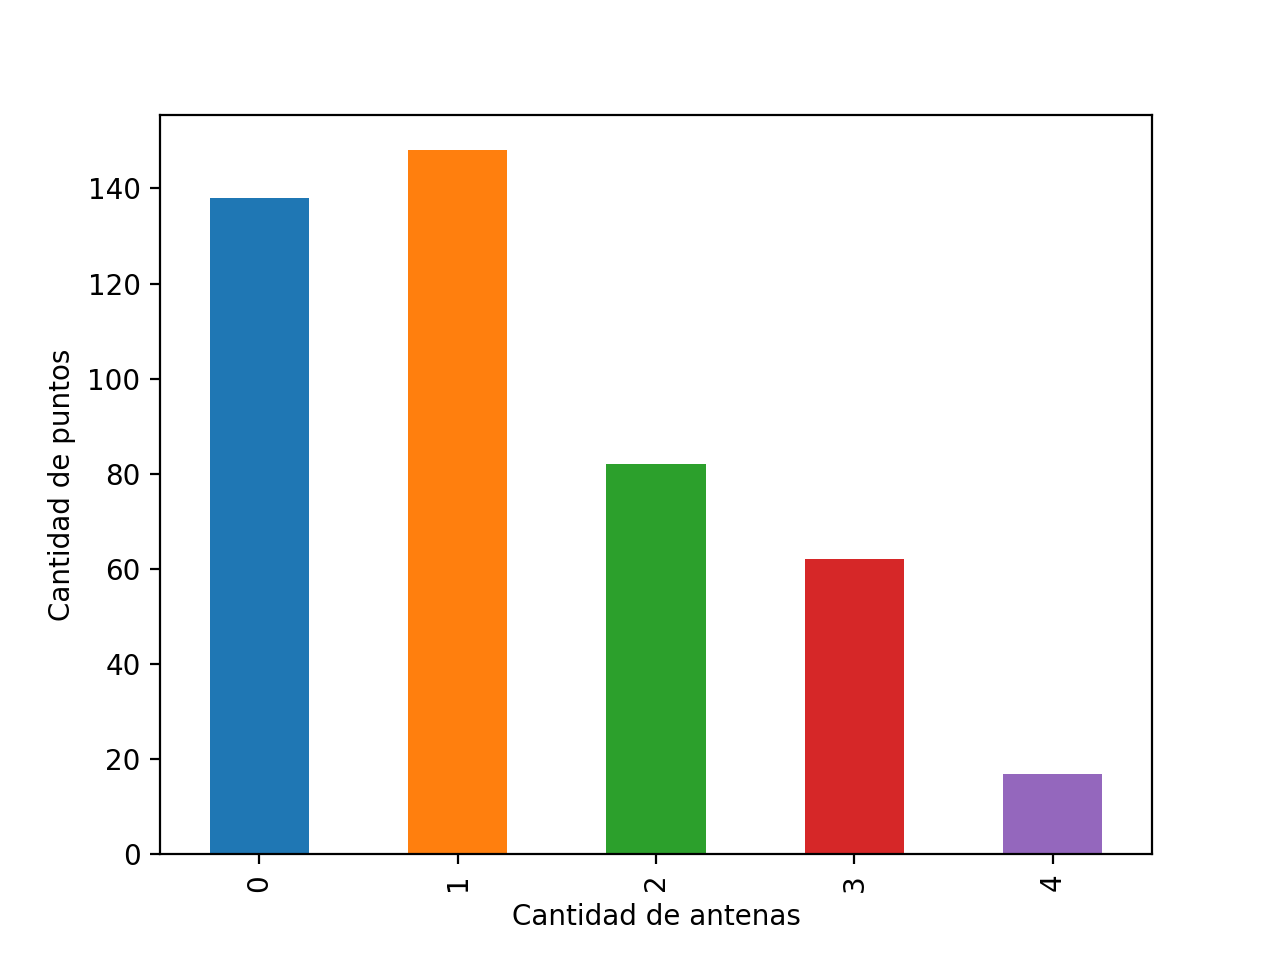

Text(0.5,0,'Cantidad de antenas')

In [78]:
p = pd.DataFrame(cant_recep.collect()).plot.bar(x='antennas', y='cant_points', legend=False)
p.set_ylabel('Cantidad de puntos')
p.set_xlabel('Cantidad de antenas')

### Relacion distancia-intensidad

#### (10) ¿Es cierto que al aumentar la distancia disminuye la potencia?

(463512.015195402, 6111004.32443462)


/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "
/Users/alew/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


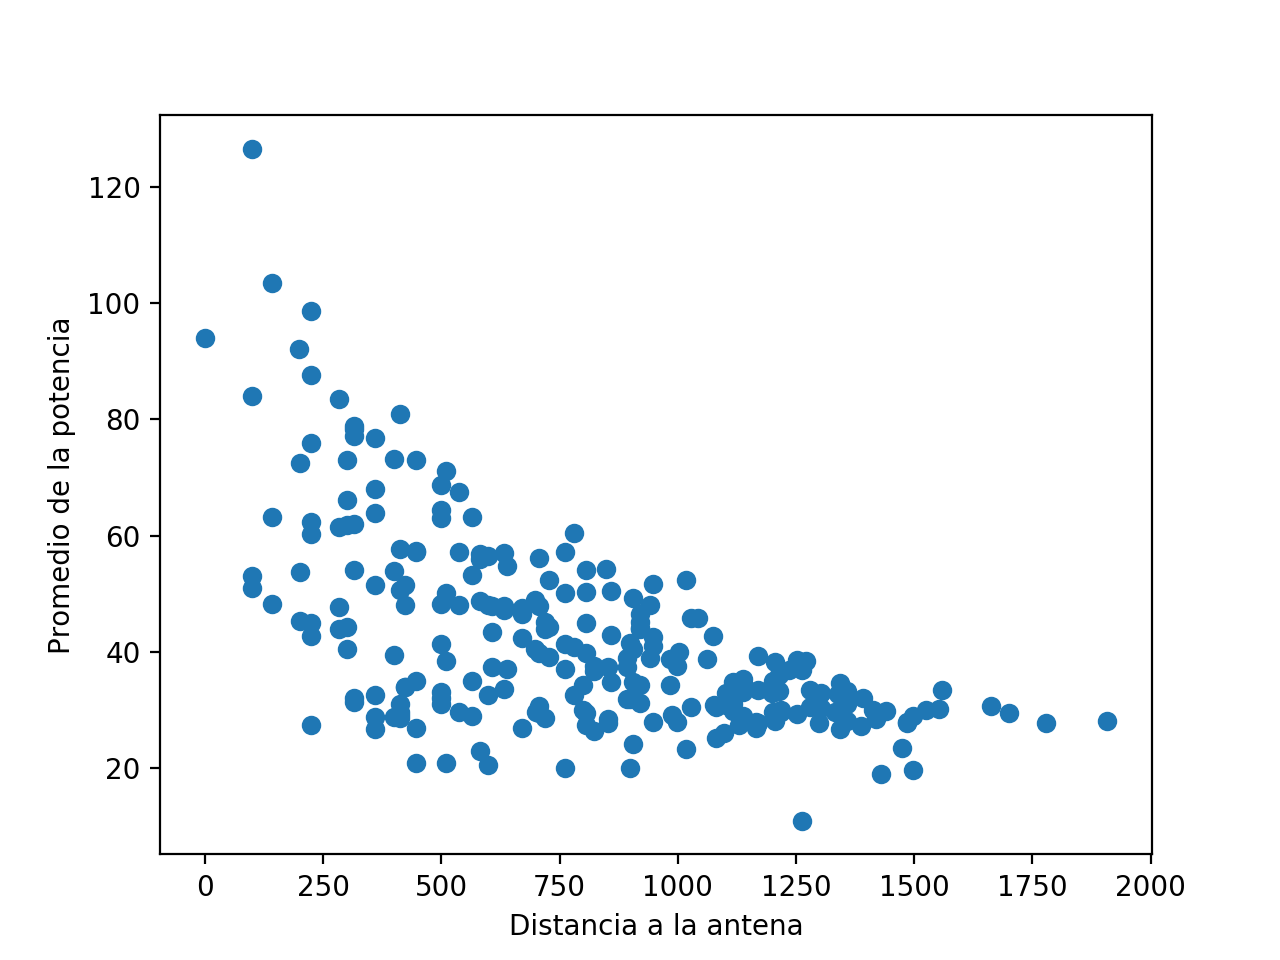

(464259.981343845, 6110331.85100085)


<IPython.core.display.Javascript object>


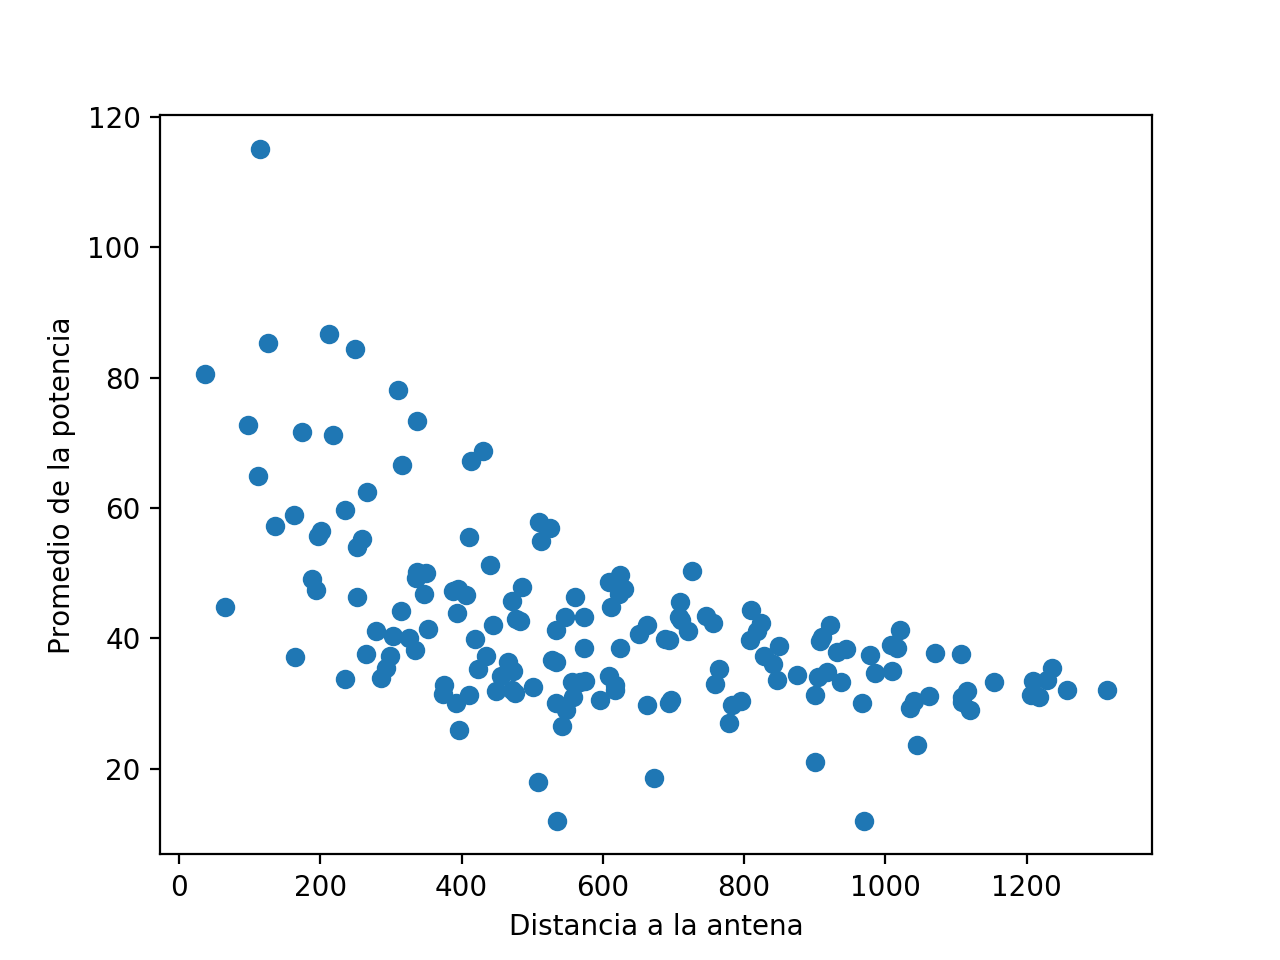

(464443.295130103, 6111377.26171875)


<IPython.core.display.Javascript object>


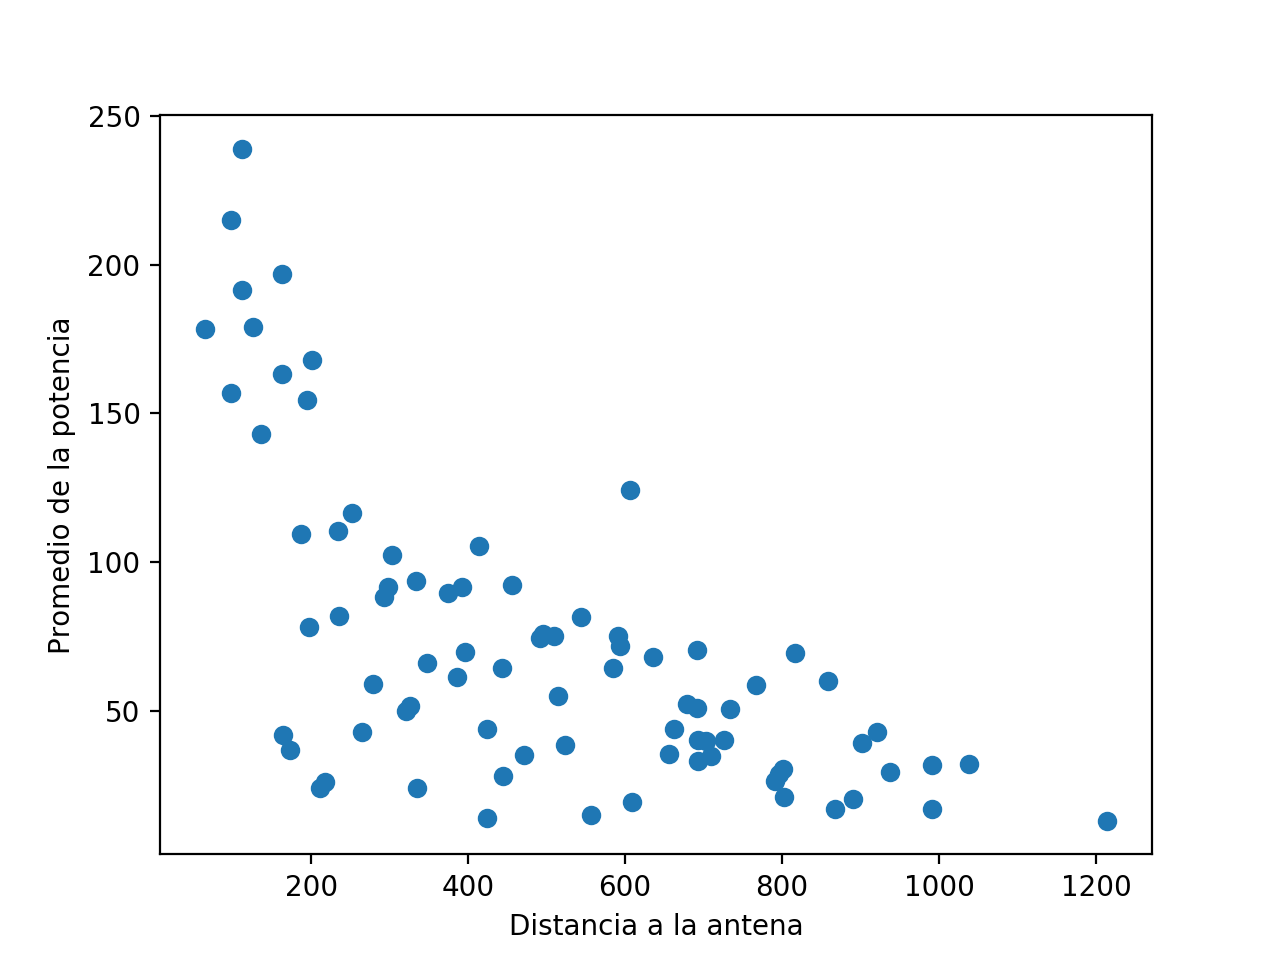

(464629.562194595, 6111105.34734669)


<IPython.core.display.Javascript object>


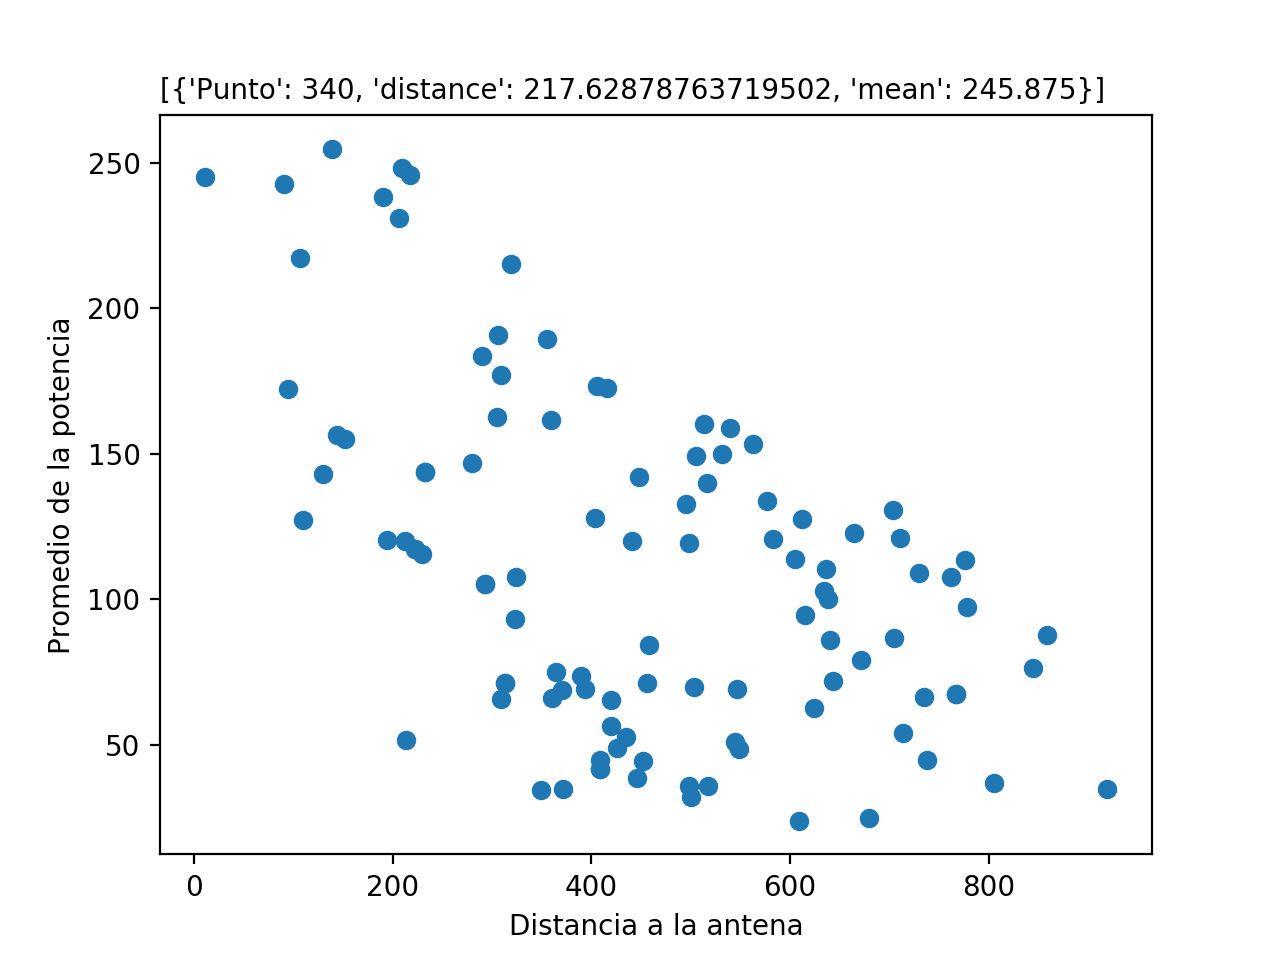

In [83]:
import math

class DataBuilder:
    def __init__(self, something, data):
        self.data = data
        self.something = something
        self.cid = something.canvas.mpl_connect('button_press_event', self)
        self.ann = plt.annotate('', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    def __call__(self, event):
        point = list(filter(lambda x: abs(x['distance']-event.xdata) < 5 and abs(x['mean']-event.ydata) < 5, self.data))
        self.ann.remove()
        self.ann = plt.annotate(str(point), (0,0), (0, 280), xycoords='axes fraction', textcoords='offset points', va='top')
        


def calculate_distance(x0,y0,x1,y1):
    return math.sqrt((x0-x1)**2+(y0-y1)**2)


        
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    pos_antena = posicion_antenas[i]
    print(pos_antena)
    p = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: {'Punto': x['Punto'],'distance': calculate_distance(pos_antena[0], pos_antena[1], x['x'], x['y']),'mean': float(np.mean(x[recep_field]))})
    p_pd = p.toDF().toPandas()
    fig, ax = plt.subplots()
    ax.scatter(p_pd['distance'], p_pd['mean'])
    ax.set_xlabel('Distancia a la antena')
    ax.set_ylabel('Promedio de la potencia')
    DataBuilder(fig, p.collect())


# Experimentos invalidos

### Las distintas emisiones de un mismo punto, tienen la misma distribucion?

In [90]:
from scipy import stats

  
def ks_test(grouped_data, antenna):
    recep_field = 'recep_{}'.format(antenna)
    emisiones = list(filter(lambda x: len(x[recep_field]), list(grouped_data[1])))
    return (grouped_data[0], stats.ks_2samp(emisiones[0][recep_field], emisiones[1][recep_field]))

for i in range(4):
    recep_field = 'recep_{}'.format(i)
    print(recep_field)
    
    points_with_many_emisions = points_recep.filter(lambda x: len(x[recep_field]) > 0).groupBy(lambda x: x['Punto']).filter(lambda x: len(x[1]) > 1)
    ks_test_by_point = points_with_many_emisions.map(lambda x: ks_test(x, i)).sortBy(lambda x: x[1].pvalue)
    print('same distribution amount {}'.format(ks_test_by_point.filter(lambda x: x[1].pvalue > 0.05).count()))
    print('total items with more than one emision for antenna {} \n'.format(points_with_many_emisions.count()))



recep_0
same distribution amount 6
total items with more than one emision for antenna 13 

recep_1
same distribution amount 2
total items with more than one emision for antenna 4 

recep_2
same distribution amount 5
total items with more than one emision for antenna 6 

recep_3
same distribution amount 6
total items with more than one emision for antenna 6 

